<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E1-UsedVehiclePricePredictionDeployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# E2 - Model Deployment in Used Vehicle Price Prediction

**INTEGRANTES:**
- Luis Alejandro Garzón Ramirez
- Zorayda Acevedo Jimenez
- Yulieth Danitza Aguillón Ortega

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [ ]:
# se toma esta libreria para hacer un descripptivo rapido
!pip install ydata-profiling

In [ ]:
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold



In [ ]:
%matplotlib inline
import pandas as pd

In [ ]:
data = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

In [ ]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


# Exercise P0.1 (50%)

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

#### Evaluation:
- 25% - Performance of the models using a manually implemented K-Fold (K=10) cross-validation
- 25% - Notebook explaining the process for selecting the best model. You must specify how the calibration of each of the parameters is done and how these change the performance of the model. It is expected that a clear comparison will be made of all implemented models.. Present the most relevant conslusions about the whole process.


In [ ]:
#Se hace un análisis exploratorio inicial
report = ProfileReport(data, explorative=True)
report.to_file("reportcarros.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Dada la cantidad de categorías en la variable modelo, se procede a hacer un enriquecimiento de información añadiendo variables de cada modelo, estas variables son cilindraje, tipo de combustible, Numero de puertas y aceleracion100km/h(s).
#### Además se elimina la variable Model dada la dificultad para su tratamiento y que se espera que las variables incluidas contengan su información.

In [ ]:
# se toma los modelos unicos para hacer enriquecimiento de la informacion
modelos = data.Model.drop_duplicates()
modelos.to_excel("datos_unicos.xlsx", index=False)

In [ ]:
#se trae el dataset con informacion adicional
datos_enriquecidos = pd.read_excel("datos_enriquecidos.xlsx")

# Realizar el join y eliminar la columna model
data = data.merge(datos_enriquecidos, on="Model", how="left")
data =data.drop(columns = "Model")
data.head()

,Price,Year,Mileage,State,Make,Cilindraje,TipoCombustible,NumeroPuertas,Aceleracion100km/h(s)
0,21490,2014,31909,MD,Nissan,4.0,Diésel,4,8.283537
1,21250,2016,25741,KY,Chevrolet,3.0,Diésel,2,4.458682
2,20925,2016,24633,SC,Hyundai,6.2,Híbrido,5,5.219662
3,14500,2012,84026,OK,Jeep,2.0,Gasolina,4,7.254475
4,32488,2013,22816,TN,Jeep,2.5,Diésel,2,7.390779


### Se procede a hacer one Hot encoding de las demás variables categorías, eliminando la primera para evitar multicolinealidad perfecta en los modelos que se ven afectados por la misma, adicionalmente para tratar la variable año se prefiere hacer una transformación tomando como referencia el año del dataset y haciendo la variable número de años transcurridos

In [ ]:
# Aplicar One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop="first")
encoded_cols = encoder.fit_transform(data[['State', 'Make','TipoCombustible']])

# Convertir a DataFrame con nombres correctos
encoded_col_names = encoder.get_feature_names_out(['State', 'Make','TipoCombustible'])
data_encoded = pd.DataFrame(encoded_cols, columns=encoded_col_names, index=data.index)  # Asegurar que los índices coincidan

# Concatenar con las columnas numéricas
data = pd.concat([data[['Year', 'Mileage', 'Price','Cilindraje','NumeroPuertas','Aceleracion100km/h(s)']], data_encoded], axis=1)

data['Años transcurridos'] = 2017 - data['Year']
data.drop(columns = "Year", inplace = True)
data.head()

,Mileage,Price,Cilindraje,NumeroPuertas,Aceleracion100km/h(s),State_ AL,State_ AR,State_ AZ,State_ CA,State_ CO,...,Make_Subaru,Make_Suzuki,Make_Tesla,Make_Toyota,Make_Volkswagen,Make_Volvo,TipoCombustible_Eléctrico,TipoCombustible_Gasolina,TipoCombustible_Híbrido,Años transcurridos
0,31909,21490,4.0,4,8.283537,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,25741,21250,3.0,2,4.458682,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,24633,20925,6.2,5,5.219662,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,84026,14500,2.0,4,7.254475,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5
4,22816,32488,2.5,2,7.390779,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
# para facilidad de manejo posterior se hace el conjunto de todas las features
features = data.columns.tolist()
features.remove('Price')

# Modelos validados con K-FOLD CV Manual

Se probaran los modelos de regresion lineal, XGBoost, arbol de desicion y Random forest regressor, para comparacion se evaluara con la metrica de RMSE.

## Regresión Lineal
Se empieza con el modelo basico para predecir una variable continua

In [ ]:
from sklearn.linear_model import LinearRegression

# Cargar los datos
df = data.copy()

# Separar características (X) y variable objetivo (y)
X = df[features]  # Suponiendo que "Precio" es la variable objetivo
y = df["Price"]

# Número de folds
k = 10
n = len(X)
indices = np.arange(n)
np.random.shuffle(indices)  # Mezclar los índices aleatoriamente

# Dividir los índices en 10 folds
folds = np.array_split(indices, k)

rmse_scores = []

# Implementación manual del K-Fold CV
for i in range(k):
    print(f"Fold {i+1}/{k}")

    # Separar datos de entrenamiento y validación
    test_idx = folds[i]
    train_idx = np.setdiff1d(indices, test_idx)

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Entrenar el modelo (Random Forest)
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    print(f"RMSE Fold {i+1}: {rmse:.4f}")

# Promedio del error en los 10 folds
mean_rmse = np.mean(rmse_scores)
print(f"\nRMSE Promedio en 10-Fold CV: {mean_rmse:.4f}")


Fold 1/10
RMSE Fold 1: 7747.0009
Fold 2/10
RMSE Fold 2: 7703.8269
Fold 3/10
RMSE Fold 3: 7679.2831
Fold 4/10
RMSE Fold 4: 7689.6954
Fold 5/10
RMSE Fold 5: 7693.6898
Fold 6/10
RMSE Fold 6: 7758.7254
Fold 7/10
RMSE Fold 7: 7730.5641
Fold 8/10
RMSE Fold 8: 7682.0711
Fold 9/10
RMSE Fold 9: 7704.4597
Fold 10/10
RMSE Fold 10: 7624.0594

RMSE Promedio en 10-Fold CV: 7701.3376


## XGBoost

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Cargar los datos
df = data.copy()

# Separar características (X) y variable objetivo (y)
X = df[features]  # Suponiendo que "Precio" es la variable objetivo
y = df["Price"]

# Número de folds
k = 10
n = len(X)
indices = np.arange(n)
np.random.shuffle(indices)  # Mezclar los índices aleatoriamente

# Dividir los índices en 10 folds
folds = np.array_split(indices, k)

rmse_scores = []

# Implementación manual del K-Fold CV con XGBoost
for i in range(k):
    print(f"Fold {i+1}/{k}")

    # Separar datos de entrenamiento y validación
    test_idx = folds[i]
    train_idx = np.setdiff1d(indices, test_idx)

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Entrenar el modelo XGBoost
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    print(f"RMSE Fold {i+1}: {rmse:.4f}")

# Promedio del error en los 10 folds
mean_rmse = np.mean(rmse_scores)
print(f"\nRMSE Promedio en 10-Fold CV: {mean_rmse:.4f}")

Fold 1/10
RMSE Fold 1: 5628.8127
Fold 2/10
RMSE Fold 2: 5807.2296
Fold 3/10
RMSE Fold 3: 5654.0012
Fold 4/10
RMSE Fold 4: 5792.2738
Fold 5/10
RMSE Fold 5: 5620.6774
Fold 6/10
RMSE Fold 6: 5601.7667
Fold 7/10
RMSE Fold 7: 5678.0585
Fold 8/10
RMSE Fold 8: 5658.3324
Fold 9/10
RMSE Fold 9: 5745.2934
Fold 10/10
RMSE Fold 10: 5690.7397

RMSE Promedio en 10-Fold CV: 5687.7185


## Arboles de decision

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Cargar los datos
df = data.copy()

# Separar características (X) y variable objetivo (y)
X = df[features]  # Suponiendo que "Precio" es la variable objetivo
y = df["Price"]

# Número de folds
k = 10
n = len(X)
indices = np.arange(n)
np.random.shuffle(indices)  # Mezclar los índices aleatoriamente

# Dividir los índices en 10 folds
folds = np.array_split(indices, k)

rmse_scores = []

# Implementación manual del K-Fold CV
for i in range(k):
    print(f"Fold {i+1}/{k}")

    # Separar datos de entrenamiento y validación
    test_idx = folds[i]
    train_idx = np.setdiff1d(indices, test_idx)

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Entrenar el modelo (Árbol de Decisión)
    model = DecisionTreeRegressor(max_depth=10, random_state=42)
    model.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    print(f"RMSE Fold {i+1}: {rmse:.4f}")

# Promedio del error en los 10 folds
mean_rmse = np.mean(rmse_scores)
print(f"\nRMSE Promedio en 10-Fold CV: {mean_rmse:.4f}")


Fold 1/10
RMSE Fold 1: 7132.4049
Fold 2/10
RMSE Fold 2: 7134.0661
Fold 3/10
RMSE Fold 3: 7120.0805
Fold 4/10
RMSE Fold 4: 7257.3304
Fold 5/10
RMSE Fold 5: 7198.1298
Fold 6/10
RMSE Fold 6: 7129.9487
Fold 7/10
RMSE Fold 7: 7172.9190
Fold 8/10
RMSE Fold 8: 7075.4573
Fold 9/10
RMSE Fold 9: 7066.7934
Fold 10/10
RMSE Fold 10: 7142.7904

RMSE Promedio en 10-Fold CV: 7142.9920


## RandomForestRegressor




In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Cargar los datos
df = data.copy()

# Separar características (X) y variable objetivo (y)
X = df[features]  # Suponiendo que "Precio" es la variable objetivo
y = df["Price"]

# Número de folds
k = 10
n = len(X)
indices = np.arange(n)
np.random.shuffle(indices)  # Mezclar los índices aleatoriamente

# Dividir los índices en 10 folds
folds = np.array_split(indices, k)

rmse_scores = []

# Implementación manual del K-Fold CV
for i in range(k):
    print(f"Fold {i+1}/{k}")

    # Separar datos de entrenamiento y validación
    test_idx = folds[i]
    train_idx = np.setdiff1d(indices, test_idx)

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Entrenar el modelo (Random Forest)
    model = RandomForestRegressor(n_estimators=50, random_state=42,n_jobs=-1)
    model.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    print(f"RMSE Fold {i+1}: {rmse:.4f}")

# Promedio del error en los 10 folds
mean_rmse = np.mean(rmse_scores)
print(f"\nRMSE Promedio en 10-Fold CV: {mean_rmse:.4f}")


Fold 1/10
RMSE Fold 1: 3725.5724
Fold 2/10
RMSE Fold 2: 3718.3936
Fold 3/10
RMSE Fold 3: 3764.3727
Fold 4/10
RMSE Fold 4: 3748.4954
Fold 5/10
RMSE Fold 5: 3818.9686
Fold 6/10
RMSE Fold 6: 3736.4183
Fold 7/10
RMSE Fold 7: 3807.7649
Fold 8/10
RMSE Fold 8: 3778.1230
Fold 9/10
RMSE Fold 9: 3696.6751
Fold 10/10
RMSE Fold 10: 3797.1336

RMSE Promedio en 10-Fold CV: 3759.1918


Los modelos con menor desempeño tomando como metrica el RMSE en un K-FOLD CV de 10 son la regresión lineal y los arboles de decision dado que el error promedio es de 7.701 y 7142 dolares respectivamente, el XGBOOST logra bajar este error a 5.687 en promedio, por ultimo el random forest regressor logra un RMSE de 3.755 por lo cual se toma entonces como mejor modelo.

###Con el mejor modelo vamos a definir una grilla para poder elegir los parametros que mas se adapten a nuestro problema, esta tiene algunos ajustes para que se pueda correr dada la limitación computacional.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

# Dividir datos en train y test
train_data, test_data, train_y, test_y = train_test_split(
    data[features], data["Price"], random_state=42, test_size=0.25
)

# Definir el modelo
model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Definir el espacio de búsqueda para la grilla de parámetros
param_grid = {
    "n_estimators": [50, 100, 200],  # Número de árboles
    "max_depth": [10, 20, 30, None],  # Profundidad máxima del árbol
    "min_samples_split": [2, 5, 10],  # Mínimo de muestras para dividir un nodo
    "min_samples_leaf": [1, 2, 4],  # Mínimo de muestras en una hoja
    "max_features": ["sqrt", "log2"],  # Número de características consideradas en cada división
}

# Configurar la búsqueda aleatoria
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=20,
    scoring="neg_root_mean_squared_error",  # Minimizar el RMSE
    cv=3,  # 3-Fold Cross Validation para reducir carga computacional
    verbose=2,
    n_jobs=-1
)

# Entrenar la búsqueda de hiperparámetros
random_search.fit(train_data, train_y)

# Mejor combinación de parámetros
best_params = random_search.best_params_
print(f"Mejores parámetros: {best_params}")

# Entrenar el modelo final con los mejores parámetros
best_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_model.fit(train_data, train_y)

# Hacer predicciones
y_pred = best_model.predict(test_data)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print(f"RMSE con mejores parámetros: {rmse:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
RMSE con mejores parámetros: 3744.3428


## Corriendo el modelo elegido con los mejores parametros




In [ ]:
train_data, test_data, train_y, test_y = train_test_split(data[features], data.Price,
                                                   random_state = 42, test_size = 0.25)

# Entrenar el modelo (Random Forest)
model = RandomForestRegressor( n_estimators = 100, min_samples_split= 10, min_samples_leaf= 1, max_features= 'log2', max_depth= None,n_jobs=-1)
model.fit(train_data, train_y)

# Hacer predicciones
y_pred = model.predict(test_data)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 3745.6731


Vemos que el efecto no es tan significativo sobre el RMSE respecto al random forest sin ajuste de parametros, sin embargo, dada la mejora se procede a trabajar con este ultimo modelo.

# Exercise P0.2 (50%)

Create an API of the model.

Example:
![](https://github.com/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/img/img015.PNG?raw=true)

#### Evaluation:
- 40% - API hosted on a cloud service
- 10% - Show screenshots of the model doing the predictions on the local machine


In [ ]:
!pip install flask-restx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
import joblib
joblib.dump(model, 'randomforest.pkl', compress=3)

['randomforest.pkl']

In [ ]:
loaded_model = joblib.load('randomforest.pkl')

In [ ]:
from flask import Flask, request, jsonify, redirect
from flask_swagger_ui import get_swaggerui_blueprint
import joblib
import pandas as pd

app = Flask(__name__)

# Cargar el modelo
model = joblib.load('randomforest.pkl')

# Configuración de Swagger
SWAGGER_URL = "/docs"
API_URL = "/swagger.json"
swaggerui_blueprint = get_swaggerui_blueprint(SWAGGER_URL, API_URL)
app.register_blueprint(swaggerui_blueprint, url_prefix=SWAGGER_URL)

@app.route('/')
def home():
    return redirect(SWAGGER_URL)

@app.route('/swagger.json')
def swagger_json():
    return jsonify({
        "swagger": "2.0",
        "info": {
            "title": "API de Predicción de Precios",
            "version": "1.0.0"
        },
        "paths": {
            "/predict": {
                "post": {
                    "summary": "Predicción de Precios",
                    "description": "Envía datos del vehículo y obtiene una predicción.",
                    "parameters": [
                        {
                            "in": "body",
                            "name": "body",
                            "required": True,
                            "schema": {
                                "example": {
                                    "Mileage": 12000,
                                    "Cilindraje": 2.0,
                                    "NumeroPuertas": 4,
                                    "Aceleracion100km/h(s)": 8.5,
                                    "State_ AL": 1,
                                    "Make_Audi": 1,
                                    "Make_Toyota": 0,
                                    "TipoCombustible_Gasolina": 1,
                                    "Años transcurridos": 5
                                }
                            }
                        }
                    ],
                    "responses": {
                        "200": {
                            "description": "Predicción exitosa",
                            "schema": {
                                "example": {"predictions": [25000]}
                            }
                        },
                        "400": {
                            "description": "Error en la solicitud",
                            "schema": {
                                "example": {"error": "Mensaje de error"}
                            }
                        }
                    }
                }
            }
        }
    })

# Endpoint de predicción
@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.json
        df = pd.DataFrame(data, index=[0])

        expected_columns = [
            'Mileage', 'Cilindraje', 'NumeroPuertas', 'Aceleracion100km/h(s)',
            'State_ AL', 'State_ AR', 'State_ AZ', 'State_ CA', 'State_ CO', 'State_ CT',
            'State_ DC', 'State_ DE', 'State_ FL', 'State_ GA', 'State_ HI', 'State_ IA',
            'State_ ID', 'State_ IL', 'State_ IN', 'State_ KS', 'State_ KY', 'State_ LA',
            'State_ MA', 'State_ MD', 'State_ ME', 'State_ MI', 'State_ MN', 'State_ MO',
            'State_ MS', 'State_ MT', 'State_ NC', 'State_ ND', 'State_ NE', 'State_ NH',
            'State_ NJ', 'State_ NM', 'State_ NV', 'State_ NY', 'State_ OH', 'State_ OK',
            'State_ OR', 'State_ PA', 'State_ RI', 'State_ SC', 'State_ SD', 'State_ TN',
            'State_ TX', 'State_ UT', 'State_ VA', 'State_ VT', 'State_ WA', 'State_ WI',
            'State_ WV', 'State_ WY', 'Make_Audi', 'Make_BMW', 'Make_Bentley',
            'Make_Buick', 'Make_Cadillac', 'Make_Chevrolet', 'Make_Chrysler',
            'Make_Dodge', 'Make_FIAT', 'Make_Ford', 'Make_Freightliner', 'Make_GMC',
            'Make_Honda', 'Make_Hyundai', 'Make_INFINITI', 'Make_Jaguar', 'Make_Jeep',
            'Make_Kia', 'Make_Land', 'Make_Lexus', 'Make_Lincoln', 'Make_MINI',
            'Make_Mazda', 'Make_Mercedes-Benz', 'Make_Mercury', 'Make_Mitsubishi',
            'Make_Nissan', 'Make_Pontiac', 'Make_Porsche', 'Make_Ram', 'Make_Scion',
            'Make_Subaru', 'Make_Suzuki', 'Make_Tesla', 'Make_Toyota',
            'Make_Volkswagen', 'Make_Volvo', 'TipoCombustible_Eléctrico',
            'TipoCombustible_Gasolina', 'TipoCombustible_Híbrido', 'Años transcurridos'
        ]

        for col in expected_columns:
            if col not in df.columns:
                df[col] = 0

        df = df[expected_columns]

        prediction = model.predict(df)[0]

        return jsonify(predictions=[prediction])

    except Exception as e:
        return jsonify(error=str(e)), 400

if __name__ == '__main__':
    app.run(debug=False, host='0.0.0.0', port=5000)

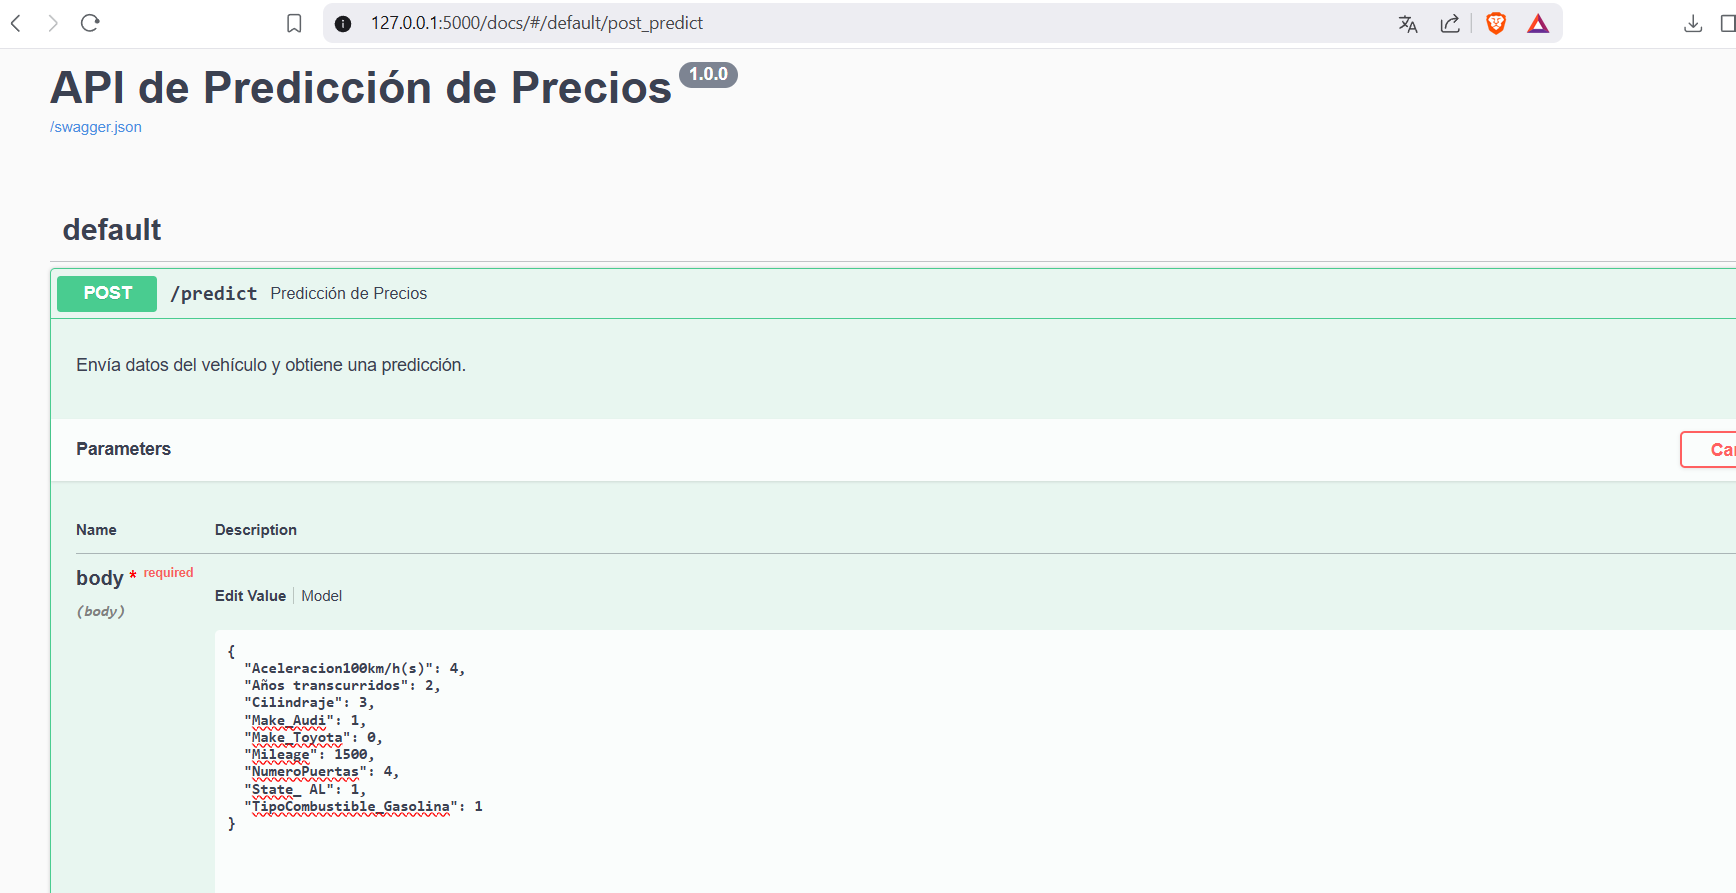

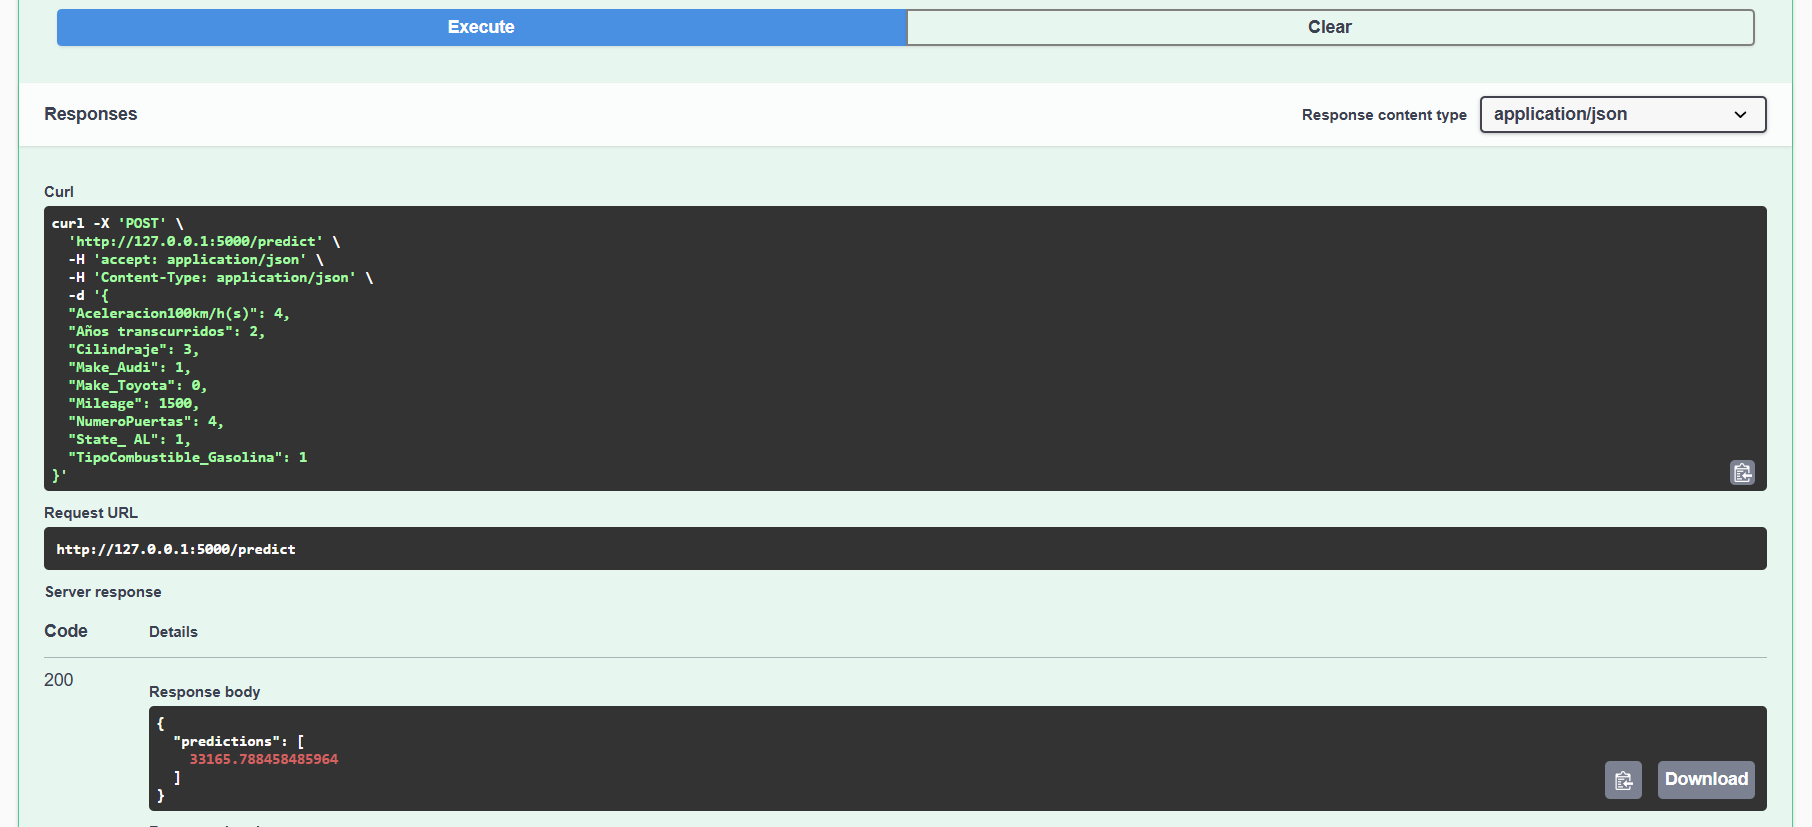

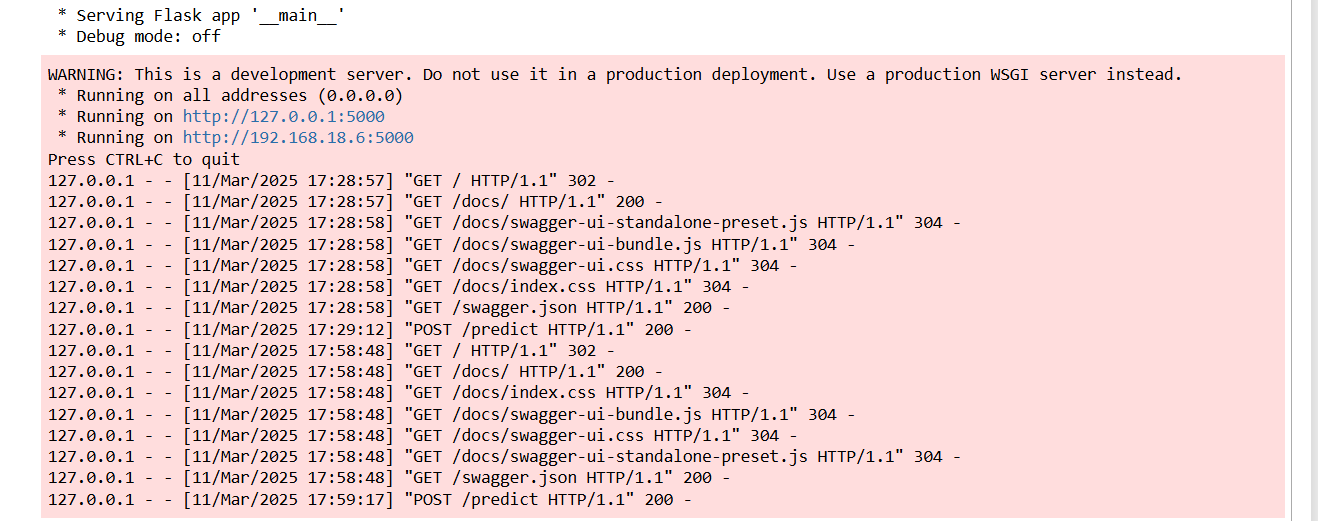